In [32]:
from statsbombpy import sb
import pandas as pd
import networkx as nx
from apriori import frequent_singletons, generate_candidates, count_support, apriori_graph_mining

I de første celler er Thors kode fra "passing seqeunces creation.ipynb" kopieret.
Jeg laver en ny markdown celle, når koden begynder at adskille sig.

In [2]:
#find ids for barca home matches - only home games because then locations can be compared between different games
matches = sb.matches(competition_id=11, season_id=90)
barca_home_matches = matches[matches["home_team"]=="Barcelona"]
match_ids = barca_home_matches['match_id'].values.tolist()

/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [3]:
#All events sorted for barca home games and possession 
events = sb.competition_events(
    country="Spain",
    division= "La Liga",
    season="2020/2021",
    gender="male"
)
events = events[events['match_id'].isin(match_ids)]
df = events[events["team"]=="Barcelona"]
df = df[df["possession_team"]=="Barcelona"]

/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/morten/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warning

In [4]:
#filter threshold for Xg:
df_xg = df[~df['shot_statsbomb_xg'].between(0, 0.05)]

In [5]:
#Events sorted in a specific order so each passing sequence is correctly sorted
sequences_sorted = df_xg.sort_values(['match_id', 'period','timestamp'], ascending=[True, True, True])

In [6]:
#make new ids because right now there is ids from 1 to x for each match but it repeats from 1 and up in every match so each possession id points to different matches 
# - i just put the possession id after match_id in the newly created id
sequences_sorted['possession_id'] = sequences_sorted['match_id'].astype(str) + sequences_sorted['possession'].astype(str)
sequences_sorted['possession_id'] = sequences_sorted['possession_id'].astype(int)

/var/folders/dl/s9k442mn7m1077_4b28hhf6c0000gn/T/ipykernel_45312/955078220.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_sorted['possession_id'] = sequences_sorted['match_id'].astype(str) + sequences_sorted['possession'].astype(str)


In [7]:
#get the ids of sequences which contain a shot (contain an xg value)
shot_sequences = sequences_sorted[sequences_sorted["shot_statsbomb_xg"].notna()]
shot_sequences_ids = shot_sequences["possession_id"].unique()

In [8]:
#filter for possession sequences which end with a shot
sequences_filtered = sequences_sorted[sequences_sorted['possession_id'].isin(shot_sequences_ids)]

In [9]:
#fill all rows with an xg for the corresponding sequence - right now there are many missing values in "shot_statsbomb_xg"
sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))

/var/folders/dl/s9k442mn7m1077_4b28hhf6c0000gn/T/ipykernel_45312/2851514471.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
/var/folders/dl/s9k442mn7m1077_4b28hhf6c0000gn/T/ipykernel_45312/2851514471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transf

In [10]:
#find ids of those possessions that result in a goal
goal_posession_index = sequences_filtered.loc[sequences_filtered["shot_outcome"]=="Goal", "possession_id"]

In [11]:
#now we dont need the shot event rows any more so remove them
sequences_filtered = sequences_filtered[sequences_filtered["type"]!="Shot"]

Nu begynder jeg at arbejde på, at lave spillerne til nodes

In [20]:
#filter the df to only include row with an id the of a pass recipient and we subset the columns

player_final_sequences =  sequences_filtered[sequences_filtered["pass_recipient"].notna()][["player_id", "pass_recipient_id", "possession_id", "xg"]]
player_final_sequences['sequence'] = player_final_sequences.groupby('possession_id').cumcount(ascending=False) + 1



In [21]:
#remove sequences with few passes if wanted
index_counts = player_final_sequences['possession_id'].value_counts()
player_final_sequences = player_final_sequences[player_final_sequences['possession_id'].isin(index_counts[index_counts > 5].index)]

In [22]:
#get all the unique possession ids for iteration
possession_index = player_final_sequences["possession_id"].unique()

In [26]:
graphs_dict = {}
for j in possession_index:
    edges = []
    for i in player_final_sequences.index:
        if j == player_final_sequences["possession_id"][i]:
            edge = (player_final_sequences["player_id"][i], player_final_sequences["pass_recipient_id"][i])
            edges.append(edge)
            if j not in graphs_dict:
                graphs_dict[j] = {"xg": player_final_sequences["xg"][i], "graph": None}
            else:
                graphs_dict[j]["xg"] = player_final_sequences["xg"][i]

    graph = nx.DiGraph()
    graph.add_edges_from(edges)

    # Add sequence as an edge attribute
    for i in player_final_sequences.index:
        if j == player_final_sequences["possession_id"][i]:
            graph[player_final_sequences["player_id"][i]][player_final_sequences["pass_recipient_id"][i]]['sequence'] = player_final_sequences["sequence"][i]

    graphs_dict[j]["graph"] = graph

graph_list = [value["graph"] for value in graphs_dict.values()]

In [28]:
edge_matrix = [list(graph.edges()) for graph in graph_list]
GRAPH_DB = graph_list  # List of graphs in the database
min_sup = 0

In [33]:
frequents = apriori_graph_mining(5, edge_matrix, GRAPH_DB, 5)
for pattern in frequents:
    print(pattern.edges())


Iteration 2:


IndexError: list index out of range

man kunne gøre noget med at fixere spillerene på deres positioner på banen for at visualisere det. Det gider jeg ikke at bruge tid på lige nu

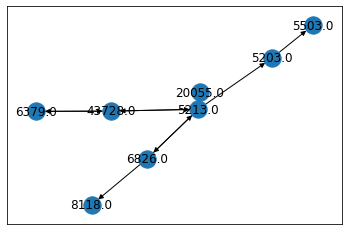

In [56]:
import matplotlib.pyplot as plt
import networkx as nx

game_pos = 377366114

# Draw the graph using the positions
nx.draw_networkx(graphs_dict[game_pos]["graph"])

# Show the plot
plt.show()


In [72]:
len(graphs_dict)

93